In [4]:
from GT import get_dataset, denormalize
import matplotlib.pyplot as plt
from GT import GTLSTM
import json
import torch
from MMD import mmd_poly, mmd_linear, mmd_rbf
import numpy as np
import os
from tsl.datasets import PemsBay, PemsBay, PemsBay

DATASET_NAME = 'PemsBay'
MODEL_NAME= 'GTLSTM'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [5]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [6]:
# Model Parameters 100 hidden
hidden_size = 64
num_layers = 1
lr = 0.1 
dropout = 0
bidirectional = True
debug = False
train_from_checkpoint = False
dataset = PemsBay()


## Dataset

In [7]:
dataset = dataset.dataframe()[-5000:]

In [8]:
dataset

nodes,400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,...,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
channels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-06-13 15:20:00,71.199997,24.299999,52.500000,58.900002,56.700001,68.199997,58.200001,55.000000,54.200001,13.900000,...,68.099998,65.199997,64.099998,61.400002,58.400002,59.099998,70.900002,64.099998,67.199997,65.199997
2017-06-13 15:25:00,70.699997,26.700001,50.700001,59.599998,58.599998,68.199997,55.299999,53.900002,50.700001,14.400000,...,67.000000,64.000000,64.199997,61.000000,57.799999,58.900002,71.099998,64.099998,67.300003,65.900002
2017-06-13 15:30:00,70.900002,27.000000,51.599998,59.200001,59.299999,68.300003,57.599998,54.000000,52.099998,14.400000,...,67.699997,65.099998,64.400002,60.700001,61.000000,59.200001,71.000000,63.799999,67.500000,65.800003
2017-06-13 15:35:00,72.300003,29.299999,51.900002,57.799999,60.299999,67.300003,57.799999,54.200001,50.299999,13.800000,...,66.800003,64.599998,63.900002,60.400002,60.299999,58.000000,71.000000,63.900002,66.500000,65.199997
2017-06-13 15:40:00,72.599998,30.000000,52.799999,57.799999,58.400002,66.900002,57.099998,53.799999,50.099998,12.900000,...,67.599998,64.400002,64.300003,61.700001,61.099998,56.599998,70.500000,62.799999,66.000000,63.599998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-30 23:35:00,70.900002,66.300003,68.400002,61.000000,61.799999,66.900002,66.000000,67.400002,65.400002,69.300003,...,64.599998,66.800003,64.699997,61.099998,68.400002,61.400002,70.500000,68.199997,71.599998,66.199997
2017-06-30 23:40:00,71.300003,66.599998,68.699997,60.900002,62.000000,66.199997,66.500000,68.199997,64.900002,69.099998,...,65.099998,67.300003,64.800003,60.799999,69.800003,62.200001,69.400002,68.599998,71.599998,68.400002
2017-06-30 23:45:00,71.400002,66.900002,68.099998,61.099998,62.000000,66.699997,65.800003,68.199997,64.199997,69.099998,...,64.900002,66.500000,64.599998,61.299999,69.500000,63.799999,70.599998,68.400002,71.599998,66.599998


In [9]:
# Dataset Split\
Train, Validation, Test = get_dataset('PemsBay', dataset=dataset)

train_data = Train
train_data = torch.Tensor(train_data)
train_label = train_data
train_data = train_data[:-1]
train_label = train_label[1:]

validation_data = Validation
validation_data = torch.Tensor(validation_data)
validation_label = validation_data
validation_data = validation_data[:-1]
validation_label = validation_label[1:]

input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)

PemsBay DATA
________________________________________
Original Dataset: 	5000
Train Split: 		4500 	(70%)
Validation Split: 	250 	(20%)
Test Split: 		250 	(10%)
________________________________________


## Model Train

In [10]:
# Model Train
model = GTLSTM(input_size, output_size, hidden_size, dropout, num_layers, bidirectional, 'mse', lr, ['EarlyStopping'], DEVICE)

configs = input_size, output_size, hidden_size, dropout, num_layers, bidirectional, 'mse', lr, ['EarlyStopping']
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except:
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, train_label, 32, 25, 10)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

Model not present or incompatible
Starting training...


Loss 0.013571271448270649, MAE : 0.08190558470310048: 100%|██████████| 141/141 [00:17<00:00,  7.94it/s]


Epoch 1 - MSE: 0.013571271448270649 - MAE: 0.08190558470310048


Loss 0.01235207257435677, MAE : 0.07657088997199181: 100%|██████████| 141/141 [00:17<00:00,  7.92it/s] 


Epoch 2 - MSE: 0.01235207257435677 - MAE: 0.07657088997199181


Loss 0.011441645998481317, MAE : 0.07246837619665666: 100%|██████████| 141/141 [00:17<00:00,  8.03it/s]


Epoch 3 - MSE: 0.011441645998481317 - MAE: 0.07246837619665666


Loss 0.010736265450927382, MAE : 0.06924252431337716: 100%|██████████| 141/141 [00:17<00:00,  8.02it/s]


Epoch 4 - MSE: 0.010736265450927382 - MAE: 0.06924252431337716


Loss 0.010170800533766547, MAE : 0.06664927589132431: 100%|██████████| 141/141 [00:17<00:00,  8.10it/s]


Epoch 5 - MSE: 0.010170800533766547 - MAE: 0.06664927589132431


Loss 0.009702532965002965, MAE : 0.06450807934640147: 100%|██████████| 141/141 [00:17<00:00,  8.03it/s]


Epoch 6 - MSE: 0.009702532965002965 - MAE: 0.06450807934640147


Loss 0.009302635934758694, MAE : 0.06268780736635762: 100%|██████████| 141/141 [00:17<00:00,  8.09it/s] 


Epoch 7 - MSE: 0.009302635934758694 - MAE: 0.06268780736635762


Loss 0.00895133389470478, MAE : 0.061092431663621403: 100%|██████████| 141/141 [00:17<00:00,  8.03it/s] 


Epoch 8 - MSE: 0.00895133389470478 - MAE: 0.061092431663621403


Loss 0.008634966312650037, MAE : 0.05965312676015475: 100%|██████████| 141/141 [00:17<00:00,  8.05it/s] 


Epoch 9 - MSE: 0.008634966312650037 - MAE: 0.05965312676015475


Loss 0.008344117703959875, MAE : 0.058322338664785346: 100%|██████████| 141/141 [00:17<00:00,  8.03it/s]


Epoch 10 - MSE: 0.008344117703959875 - MAE: 0.058322338664785346


Loss 0.008072372868571246, MAE : 0.05706938073461783: 100%|██████████| 141/141 [00:17<00:00,  8.08it/s] 


Epoch 11 - MSE: 0.008072372868571246 - MAE: 0.05706938073461783


Loss 0.007815462029340895, MAE : 0.05587414461881556: 100%|██████████| 141/141 [00:17<00:00,  7.96it/s] 


Epoch 12 - MSE: 0.007815462029340895 - MAE: 0.05587414461881556


Loss 0.007570652785737411, MAE : 0.054724553718845895: 100%|██████████| 141/141 [00:17<00:00,  8.10it/s]


Epoch 13 - MSE: 0.007570652785737411 - MAE: 0.054724553718845895


Loss 0.007336308639694719, MAE : 0.05361462109689171: 100%|██████████| 141/141 [00:17<00:00,  7.95it/s] 


Epoch 14 - MSE: 0.007336308639694719 - MAE: 0.05361462109689171


Loss 0.007111557399365285, MAE : 0.052541610632910796: 100%|██████████| 141/141 [00:17<00:00,  7.99it/s] 


Epoch 15 - MSE: 0.007111557399365285 - MAE: 0.052541610632910796


Loss 0.00689604156980859, MAE : 0.0515046828551918: 100%|██████████| 141/141 [00:17<00:00,  8.14it/s]   


Epoch 16 - MSE: 0.00689604156980859 - MAE: 0.0515046828551918


Loss 0.006689723764367877, MAE : 0.050505347193238584: 100%|██████████| 141/141 [00:17<00:00,  8.13it/s] 


Epoch 17 - MSE: 0.006689723764367877 - MAE: 0.050505347193238584


Loss 0.006492741702368866, MAE : 0.04954576126385665: 100%|██████████| 141/141 [00:17<00:00,  8.16it/s]  


Epoch 18 - MSE: 0.006492741702368866 - MAE: 0.04954576126385665


Loss 0.0063052966023286715, MAE : 0.048628588398614676: 100%|██████████| 141/141 [00:17<00:00,  8.17it/s]


Epoch 19 - MSE: 0.0063052966023286715 - MAE: 0.048628588398614676


Loss 0.0061275753372593235, MAE : 0.04775530550338275: 100%|██████████| 141/141 [00:17<00:00,  8.21it/s] 


Epoch 20 - MSE: 0.0061275753372593235 - MAE: 0.04775530550338275


Loss 0.0059596989056135115, MAE : 0.046928112084666886: 100%|██████████| 141/141 [00:17<00:00,  8.14it/s]


Epoch 21 - MSE: 0.0059596989056135115 - MAE: 0.046928112084666886


Loss 0.00580169316604139, MAE : 0.04614813351039345: 100%|██████████| 141/141 [00:17<00:00,  8.13it/s]   


Epoch 22 - MSE: 0.00580169316604139 - MAE: 0.04614813351039345


Loss 0.005653477604550487, MAE : 0.04541650460702731: 100%|██████████| 141/141 [00:17<00:00,  8.21it/s] 


Epoch 23 - MSE: 0.005653477604550487 - MAE: 0.04541650460702731


Loss 0.005514867736706973, MAE : 0.04473264318567219: 100%|██████████| 141/141 [00:17<00:00,  8.14it/s]  


Epoch 24 - MSE: 0.005514867736706973 - MAE: 0.04473264318567219


Loss 0.005385587456328993, MAE : 0.04409568031576085: 100%|██████████| 141/141 [00:17<00:00,  8.19it/s] 


Epoch 25 - MSE: 0.005385587456328993 - MAE: 0.04409568031576085


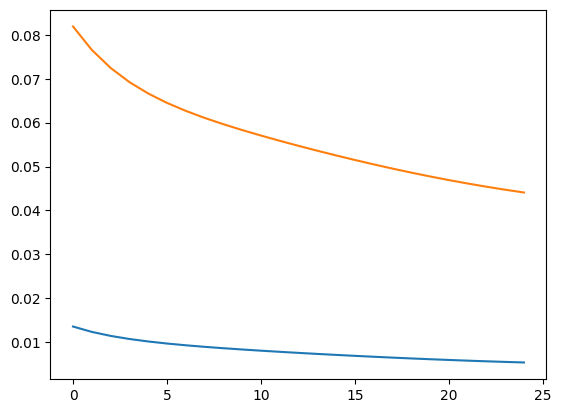

<Figure size 640x480 with 0 Axes>

In [11]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

## Predict on Train

In [22]:
SPLIT_NAME = 'Train'

# output = denormalize(model.predict_step(train_data, start=0, steps=50, mode='sum'))
output = model.predict_step(train_data, start=0, steps=900)

# data_true = denormalize(train_label[0:50, :, :].numpy())
data_true = train_label[25:100, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='PemsBay')
data_predicted = denormalize(data_predicted, name='PemsBay')
# for i in range(10):
#     first_elements_arr1 = [subarr[i] for subarr in data_true]
#     first_elements_arr2 = [subarr[i] for subarr in data_predicted]
#     # Plotting
#     plt.plot(first_elements_arr1, label='True')
#     plt.plot(first_elements_arr2, label='Predicted')
#     plt.xlabel('Index')
#     plt.ylabel('Values')
#     plt.title(f'Line Plot of Train Feature {i}')
#     plt.legend()
#     plt.show()
#     plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}.png')
#     plt.clf()

## Generate on Train

In [23]:
# # output = denormalize(model.generate_step(train_data, start=0, steps=200, mode='mean'))
# output = model.generate_step(train_data, start=0, steps=1000)

# # data_true = denormalize(train_label[0:200, :, :].numpy())
# data_true = train_label[25:100, :, :].numpy()
# data_predicted = output.reshape(output.shape[0], output.shape[-1])
# data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

# data_true = denormalize(data_true, name='PemsBay')
# data_predicted = denormalize(data_predicted, name='PemsBay')

# for i in range(10):
#     first_elements_arr1 = [subarr[i] for subarr in data_true]
#     first_elements_arr2 = [subarr[i] for subarr in data_predicted]
#     # Plotting
#     plt.plot(first_elements_arr1, label='True')
#     plt.plot(first_elements_arr2, label='Generated')
#     plt.xlabel('Index')
#     plt.ylabel('Values')
#     plt.title(f'Line Plot of Train Feature {i}')
#     plt.legend()
#     plt.show()
#     plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}_GEN.png')
#     plt.clf()

In [24]:
import pandas as pd
df = pd.DataFrame(data_predicted)
str = [400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,400073,400084,400085,400088,400096,400097,400100,400104,400109,400122,400147,400148,400149,400158,400160,400168,400172,400174,400178,400185,400201,400206,400209,400213,400221,400222,400227,400236,400238,400240,400246,400253,400257,400258,400268,400274,400278,400280,400292,400296,400298,400330,400336,400343,400353,400372,400394,400400,400414,400418,400429,400435,400436,400440,400449,400457,400461,400464,400479,400485,400499,400507,400508,400514,400519,400528,400545,400560,400563,400567,400581,400582,400586,400637,400643,400648,400649,400654,400664,400665,400668,400673,400677,400687,400688,400690,400700,400709,400713,400714,400715,400717,400723,400743,400750,400760,400772,400790,400792,400794,400799,400804,400822,400823,400828,400832,400837,400842,400863,400869,400873,400895,400904,400907,400911,400916,400922,400934,400951,400952,400953,400964,400965,400970,400971,400973,400995,400996,401014,401129,401154,401163,401167,401210,401224,401327,401351,401388,401391,401400,401403,401440,401457,401464,401489,401495,401507,401534,401541,401555,401560,401567,401597,401606,401611,401655,401808,401809,401810,401811,401816,401817,401845,401846,401890,401891,401906,401908,401926,401936,401937,401942,401943,401948,401957,401958,401994,401996,401997,401998,402056,402057,402058,402059,402060,402061,402067,402117,402118,402119,402120,402121,402281,402282,402283,402284,402285,402286,402287,402288,402289,402359,402360,402361,402362,402363,402364,402365,402366,402367,402368,402369,402370,402371,402372,402373,403225,403265,403329,403401,403402,403404,403406,403409,403412,403414,403419,404370,404434,404435,404444,404451,404452,404453,404461,404462,404521,404522,404553,404554,404585,404586,404640,404753,404759,405613,405619,405701,407150,407151,407152,407153,407155,407157,407161,407165,407172,407173,407174,407176,407177,407179,407180,407181,407184,407185,407186,407187,407190,407191,407194,407200,407202,407204,407206,407207,407321,407323,407325,407328,407331,407332,407335,407336,407337,407339,407341,407342,407344,407348,407352,407359,407360,407361,407364,407367,407370,407372,407373,407374,407710,407711,408907,408911,409524,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694]

In [25]:
df.columns = str
df.to_csv('TeachForcingPemsBayGTLSTM.csv', index=False)

In [26]:

print(mmd_linear(data_true, data_predicted))  # 6.0
print(mmd_rbf(data_true, data_predicted))  # 0.5822
print(mmd_poly(data_true, data_predicted))  # 2436.5

39576.91
0.014445681124925613
90844692480.0
